In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/export/bbq2/dfm/anaconda3/lib/python3.4/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [3]:
campaign = 1
epicid = "201270131"
# epicid = "201367065"
# epicid = "201912552"
# epicid = "201754305"

# campaign = 3
# epicid = "206475757"

# campaign = 4
# epicid = "211056809"
# epicid = "211028585"

basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    min_transits=3,
    detrend=True,
    invert=True,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    # initial_time=2179.0,
    # initial_time=2264.0,
    skip=0,
    durations=[0.05],
    min_period=1.0,
    max_period=50.,
    npeaks=3,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [4]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [5]:
r = pipe.query(**query)

Using cached value in OneDSearch
Querying IterativeTwoDSearch
Querying Data
Finished querying Data in 0.63s
Querying Likelihood
tau = 2.9967041015625
tau = 2.9967041015625
tau = 6.497955322265625
tau = 6.487762451171875
tau = 4.640380859375
tau = 4.640380859375
tau = 4.6099853515625
tau = 4.61505126953125
Finished querying Likelihood in 12.62s
Finished querying IterativeTwoDSearch in 81.72s
Querying Vetter
Finished querying Vetter in 31.27s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


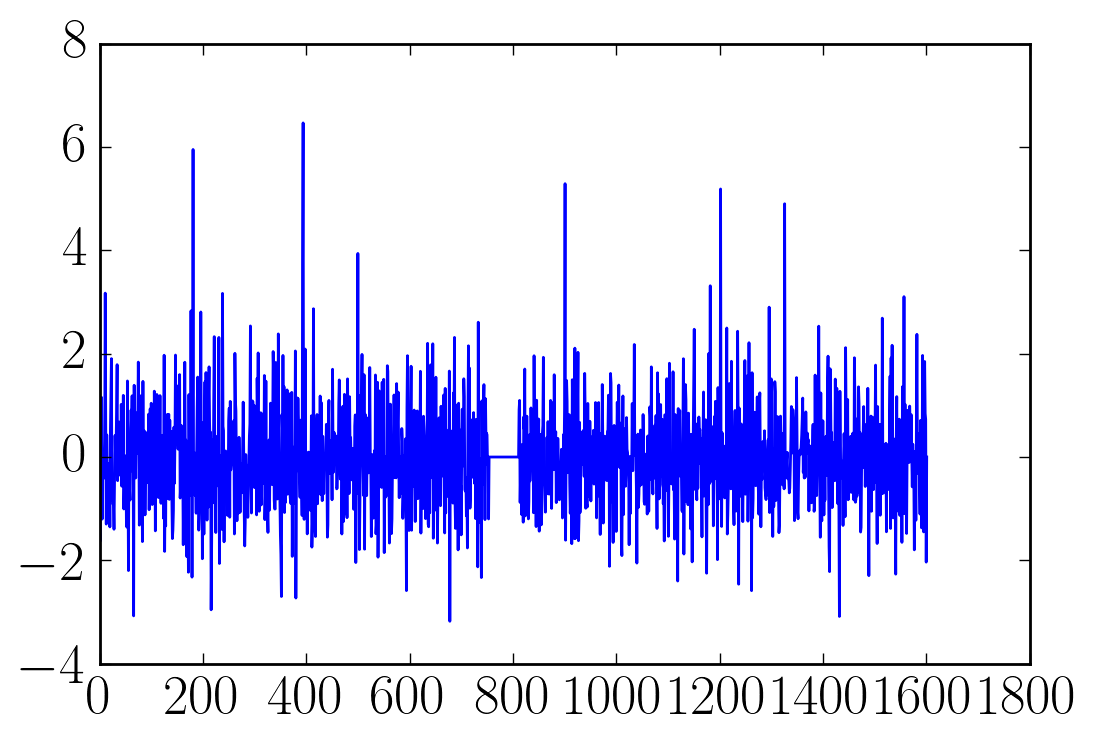

In [6]:
pl.plot(r.depth_1d * np.sqrt(r.depth_ivar_1d))

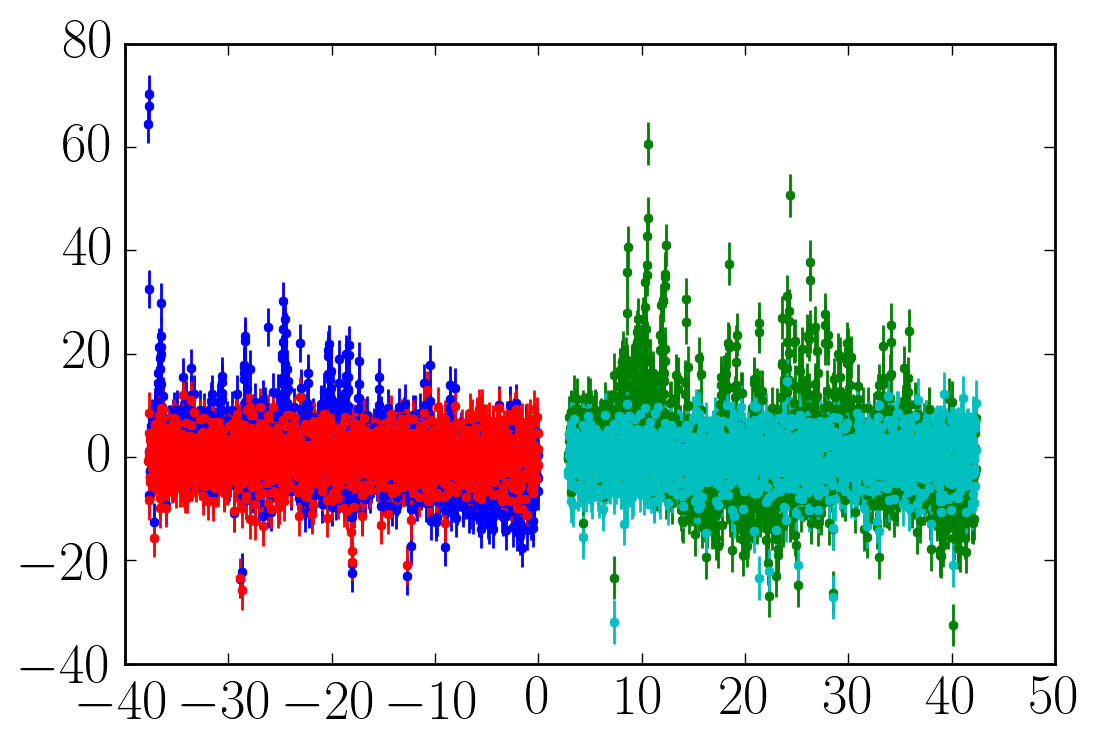

In [7]:
lcs = r.model_light_curves
[pl.errorbar(lc.time, lc.flux, yerr=lc.ferr, fmt=".", capsize=0) for lc in lcs];
[pl.errorbar(lc.time, lc.detrend_flux, yerr=lc.detrend_ferr, fmt=".", capsize=0) for lc in lcs];

In [8]:
r.peaks

[{'data_span': 80.0723876953125,
  'depth': 11.44518350327651,
  'depth_ivar': 0.48809546177488455,
  'duration': 0.05,
  'duty_cycle': 0.95692883895131087,
  'lnZ_box': -1984.8310774269983,
  'lnZ_none': -2022.3624974737481,
  'lnZ_outlier': -1975.3298500349963,
  'lnZ_period': -2014.8786689602391,
  'lnZ_transit': -1988.2561289968744,
  'lnZ_vee': -1981.7006289016763,
  'lnlike_box': -1986.2027892989508,
  'lnlike_none': -2022.3624974737481,
  'lnlike_outlier': -1979.9480206079691,
  'lnlike_period': -2014.4348393988391,
  'lnlike_transit': -1976.0119205858236,
  'lnlike_vee': -1983.6060244089917,
  'osc_period': 0.059679800026319743,
  'period': 25.363834955687373,
  'phic_same': -2095.7080131428411,
  'phic_same_second': -2110.9668923281706,
  'phic_variable': -6179.2284395228635,
  's2n': 7.996043443921959,
  't0': 7.326652338499823,
  'transit_b': 0.45813942659867185,
  'transit_duration': 0.053434887500845393,
  'transit_period': 25.388785648268911,
  'transit_q1': 0.50030015705

(6.3300743804856809, 8.3300743804856801)

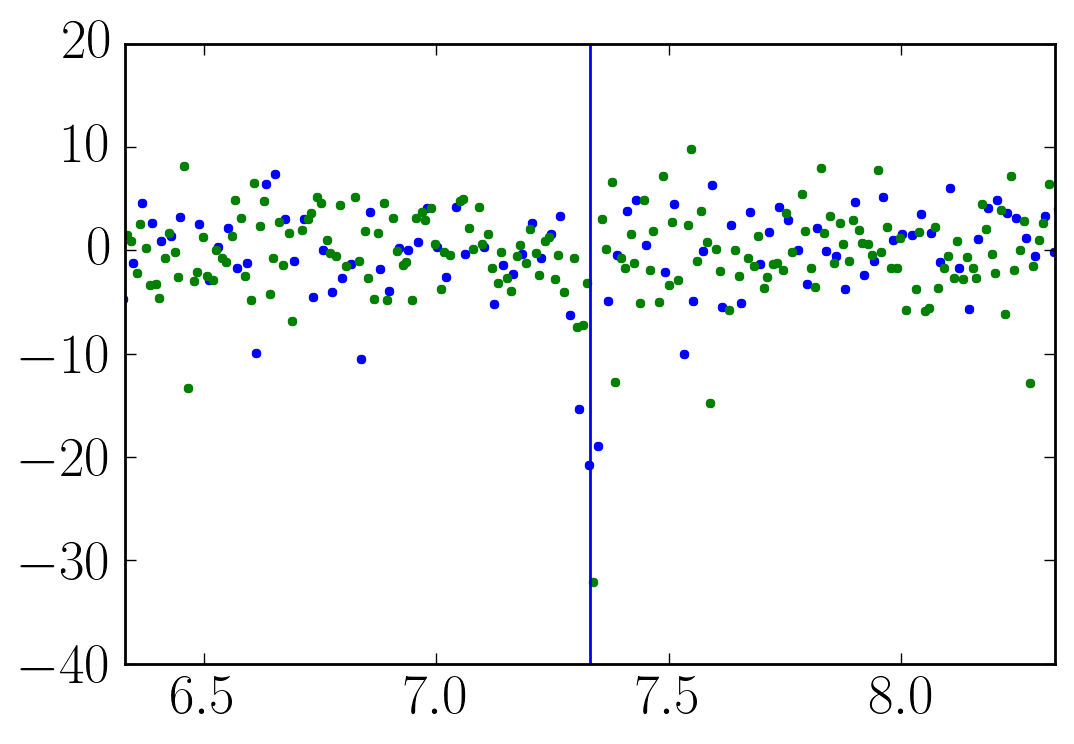

In [9]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
# [pl.plot(lc.time %  p["transit_period"], m, ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)